# Basic Machine Learning with Scikit-Learn

In this notebook we will look into the basics of building ML models with Scikit-Learn. Scikit-Learn is the most widely used Python library for ML, especially outside of deep learning (where there are several contenders and I recommend using Keras, which is a package that provides a simple API on top of several underlying contenders like TensorFlow and PyTorch).

We'll proceed in this fashion:

- give a brief overview of key terminology and the ML workflow
- illustrate the typical use of SciKit-Learn API through some simple examples
- discuss various metrics that can be used to evaluate ML models
- dive deeper with some more complex examples
- look at the various ways we can validate and improve our models
- discuss the topic of feature engineering - ML models are good examples of "garbage in, garbage out", so cleaning our data and getting the right features is important
- look at how we can combine models, and ways of interpreting the predictions we get out of our models
- finally, provide some links as launch points for further learning.

We are going to focus on practical ML, and will not be going much into the internal details of the various algorithms. We're also going to avoid the topics of *Deep Learning* and *neural nets*: these are generating a lot of hype at present but in general involve learning thousands of parameters requiring massive amounts of data for training (and a lot of time). The techniques we are going to look at can be used for much smaller problems and are generally very fast to train. It's worth having them in your toolkit and progressing to deep learning later.

> It's worth noting that getting good data and the right features is generally more important than the type of model 
> you choose to use. The performance of the different types of ML model techniques is often similar. It's commonly
> said in ML circles that 80% of time is spent on getting data cleaned up and doing *feature engineering* and only 20%
> is spent on modeling. For example, until around 2014 when deep learning started taking off, most ML models at Google 
> were trained using the same system ([Sibyl](https://users.soe.ucsc.edu/~niejiazhong/slides/chandra.pdf)), a form of boosted logistic regression that could be run on large data sets 
> with map-reduce. Deep learning has an advantage that it can
> *learn* features that would otherwise need to be engineered by hand, and can thus automate some of the manual work
> typically done by an ML engineer, but in order to do that, as mentioned above, it generally needs a massive dataset and
> often days or weeks of compute time. 

## ML Terminology

*Machine Learning* is the process of building models from data, either to gain insight into the data or to make predictions for new data (generalization). There are two main categories:

- *supervised learning*, in which the data (*training data*) is labeled with an known outcome (this is the *supervision* part), and the aim is to predict new outcomes from new data; if the outcome is a category this is called *classification* while if the outcome is a continuous quantity this is called *regression*
- *unsupervised learning*, in which the data is analyzed for underlying patterns to gain insight; common examples are *clustering* (finding similar cases), *outlier detection* (finding unusual cases), and *dimensionality reduction* (reducing the number of variables needed to represent the data, essentially a form of lossy compression)

The data used in ML is typically tabular. The columns are called *features* while the rows are *instances* or *observations*. For supervised learning, we call the  output column the *target* or *label*. We'll often refer to the vector if features as X and the output (label) as y, and say that we're trying to find a function that approximates f(X)=y; this function is our *model* and is characterized by some *model parameters*. We usually choose the type or class of model, and then use ML techniques to learn the model parameters that minimize the *error* (the difference between the predicted and actual output). More generally we can think of this as an optimization problem, where we are trying to learn the parameters that minimize a *loss function*; that loss function is typically going to be some cumulative function of the errors; a common loss function is RMSE (root mean square of errors).

While we learn the model parameters, there are some other parameters we need to specify as inputs to the model too; these are called *hyperparameters*. For example, if we learn a decision tree model, the parameters might be the features being tested at each branch and the values they are being tested against, while the hyperparameters would include the depth that we want to limit the tree to. For a polynomial regression model, the parameters would be the coefficients of the polynomial, while the hyperparameters could include the degree of polynomial we want to learn.

## ML Workflow

A typical machine learning workflow begins with:

- getting the data
- exploring and cleaning up the data (handling missing values, normalizing values, removing bad data and outliers, encoding data in appropriate representations, and more)
- possibly creating some additional synthetic values (e.g. we could use linear regression to fit a higher-order polynomial by creating synthetic values that are existing values raised to the power 2, 3, etc; other common examples might be computing and including aggregate values like means and standard deviations of some of the original values)
- picking a type of model to use, and configuring the initial hyperparameters

After which we could do multiple iterations of:

- training the model
- evaluating the results
- adjusting the model type or the hyperparameters if the results are not yet satisfactory

And this second phase could necessitate a return to the first phase, to get more data or create more synthetic features.

The hyperparameter tuning could be done manually or may itself be automated by doing a state-space search through the possible values.

After some number of iterations, if we have a model that improves upon existing capabilities, we would want to deploy it. For the model to be useful, new data that we feed to the model should have similar properties to the test data (i.e. we rely on our test set being representative of the new data). If this is not true (e.g. because the future is just different and unpredictable, or perhaps we have *overfit* the training data), the model likely will not generalize well. If it is true, then we may be done, at least for some time, but in many cases future data will eventually diverge from the past and the model will degrade. We thus need to get more recent data, retrain, retune, and redeploy. The cadence of these refreshes will depend on the particular problem we are addressing. For example, if we build a model to recognize species of flowers we may need to retrain very infrequently or possibly never, as the primary reason to retrain is that we discover species that the model has not accounted for. On the other hand, if we build a model to detect fraudulent behavior we are pitting the model against adversaries that are adaptive and intelligent and we may need constant refreshes.


## Exploring the Iris Dataset

Let's look at an example, the famous (in data science circles!) _iris flower dataset_. We'll eventually be trying to predict the species, so it will be a focus even in our initial exploratory work. The Seaborn plotting library includes this as a sample so we can load it that way:

In [1]:
# Ensure our plots are inline in the notebook
%matplotlib inline

In [ ]:
# Install dependencies
# sys.executable is the path to the Python executable; e.g. /usr/bin/python
import sys
!conda config --add channels conda-forge
!conda install --yes --prefix {sys.prefix} seaborn
!conda install --yes --prefix {sys.prefix} scikit-learn

In [2]:
# Let's import numpy and pandas while we're at it.
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns

iris = sns.load_dataset('iris')  # returns a dataframe
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We would usually start with some exploratory analysis of the data. A very common approach if the number of features is not too high is to use a *pairplot* or *scatter matrix*, which plots multiple pairwise scatterplots for each combination of pairs of features, as well as the distribution of each feature. Pandas Dataframes have a `scatter_matrix()` method to do this but Seaborn has a similar `pairplot` API that is easier to use:

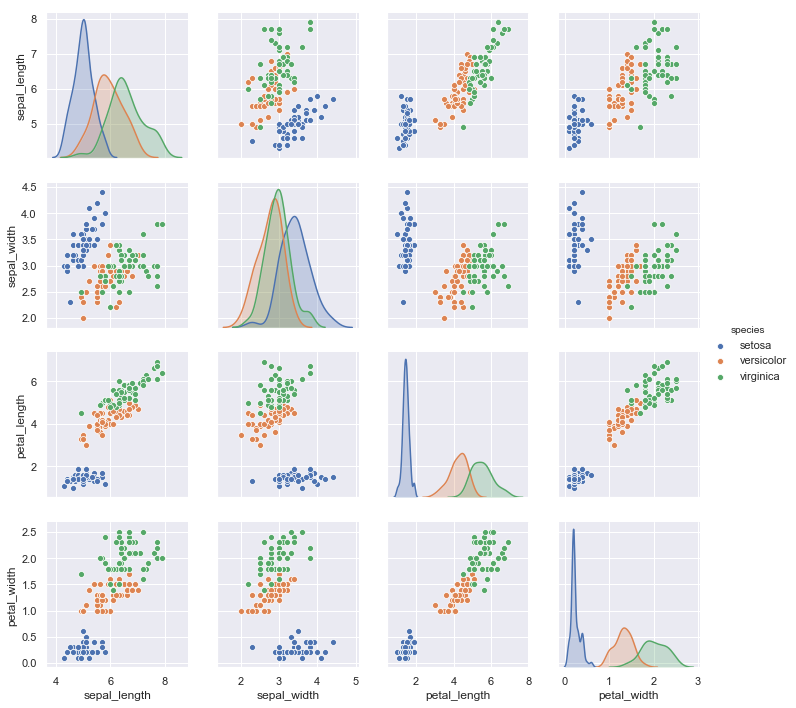

In [4]:
sns.set()  # set the default style for Seaborn

sns.pairplot(iris, hue='species');

In the pairplot, we're looking for several things: 

- are there features that are strongly correlated (or strongly inversely correlated)? If so, we may want to exclude one of the features, to simplify the model;
- are there obvious clusters, that may be linearly separable? If so we may get far with simple linear models (as opposed to more complex models like decision trees).
- are there features which seem correlated but our intuition or domain knowledge tells us should not be? In this case we may be missing features that are important to the model (these are called *confounding variables*). For example, we may see a correlation between daily ice cream consumption and drive-by shooting rates. We shouldn't expect this. It may be that the confounding variable is weather - in hotter weather people are more likely to be outside, resulting in an increase in both ice cream consumption and drive-by shootings.
- looking at the diagonal, are the distributions Gaussian (normal)? Some modeling techniques (e.g. Gaussian naive Bayes, logistic regression, and Linear Discriminant Analysis (LDA)) depend on the features having such a distribution.

For classification, we ideally want a dataset that is balanced in the number of observations of each category. We can check this with:

In [5]:
iris.groupby('species').size()

species
setosa        50
versicolor    50
virginica     50
dtype: int64

If the dataset is not balanced we can resample it, over-sampling from items from less common classes (if we don't have a lot of data) or undersampling from items with more common classes (if we have plenty of data). For more strategies to deal with this see [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

Aside from the frequency histograms on the diagonal of the scatter plot, another way of looking at the distributions is with density plots:

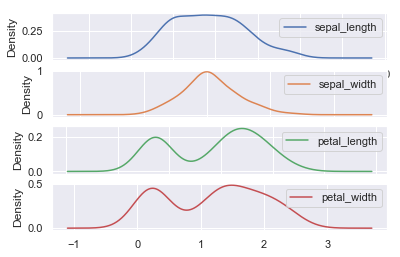

In [6]:
import matplotlib.pyplot as plt
iris.plot(kind='density', subplots=True, sharex=False)
plt.show()

Sepal length and sepal width are approximately Gaussian; petal length and petal width not so much; in fact, these are *bimodal* (see https://en.wikipedia.org/wiki/Multimodal_distribution).

If the distributions are not Gaussian, we may want to normalize them, which we can do with a Box Cox transformation. That is beyond the scope of this notebook; Google it if you need it. For this particular case of bimodal distributions, we would instead favor [Gaussian mixture models](http://scikit-learn.org/stable/modules/mixture.html). For now we will ignore these complexities, especially as this is a simple dataset. We will discuss some options for cleaning the dataset by rescaling features later.

We're not going to remove any observations here, but its worth discussing ways in which we can detect and remove outliers. There's no one solution but there are several techniques that can be used, such as:

- looking at the distribution of values for a feature, and removing the top and bottom percentiles
- computing the mean and standard deviation and removing items that are too far removed from the mean (typically something like 3x standard deviations from the mean)
- of course, mean and standard deviation are themselves sensitive to outliers, so we might combine the above techniques: compute the mean and standard deviation of the data after dropping the top and bottom percentiles as in the first method, and then using that pair of mean and standard deviation applied to the full data set s in the second method.

## A Simple Classification Model to Predict the Species

In practice, we would usually store the data in the form of a Pandas DataFrame or NumPy array, the *features matrix*, and assign it to a variable `X`. Lets get the data into the X/y form we need for training a model:

In [7]:
X = iris.drop('species', axis=1)
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
y = iris['species'] 
y.head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: object

SciKit-Learn has a simple and consistent API that makes it easy to learn. After getting the data in the right form, the steps are just:

- import the model type
- instantiate the model with the appropriate *hyperparameters*
- call the `fit()` API to learn the model parameters
- call `predict()` to predict the results for new data

We want to test our model on new data; the typical way to do this is to split the data into a *training set* and a *testing set*; a common split is 80/20 or 75/25; we'll use 20% for test:


In [9]:
from sklearn.model_selection import train_test_split
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1, test_size=0.2)


The first model type we will apply is Gaussian naive Bayes; this is simple and fast and needs no hyperparameters so it is a good baseline. It is called *naive* because it "naively" assumes all the features are independent, and *Gaussian* because it assumes each feature has a normal distribution. While that isn't true in our example we can still try it as a model:

In [10]:
from sklearn.naive_bayes import GaussianNB
        
gnbmodel = GaussianNB()
gnbmodel.fit(Xtrain, ytrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [11]:
ypredict = gnbmodel.predict(Xtest)
ypredict

array(['setosa', 'versicolor', 'versicolor', 'setosa', 'virginica',
       'versicolor', 'virginica', 'setosa', 'setosa', 'virginica',
       'versicolor', 'setosa', 'virginica', 'versicolor', 'versicolor',
       'setosa', 'versicolor', 'versicolor', 'setosa', 'setosa',
       'versicolor', 'versicolor', 'virginica', 'setosa', 'virginica',
       'versicolor', 'setosa', 'setosa', 'versicolor', 'virginica'],
      dtype='<U10')

To evaluate the model we want to know the accuracy, which we can get by comparing the actual values with the predicted values; SciKit-Learn has a helper function `accuracy_score` for this:

In [12]:
from sklearn.metrics import accuracy_score
        
accuracy_score(ytest, ypredict)

0.9666666666666667

So even a simple model with unsatisfied assumptions is almost 97% accurate on this data.

Let's look at a different model, so you can see how easy it is to switch between different approaches. We'll use a *k-nearest neighbors* model. In this case a prediction is made by finding the k-nearest observations (for some k, which is our hyperparameter). The labels associated with those observations are used to get the predicted label (if they disagree, the most commonly occurring one is picked; if there is a tie a random winner is picked):

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knnmodel = KNeighborsClassifier(n_neighbors=1)  # We'll use k=1
knnmodel.fit(Xtrain, ytrain)
ypredict = knnmodel.predict(Xtest)
accuracy_score(ytest, ypredict)

1.0

Finally, let's try a decision tree model:

In [14]:
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier(max_depth=4)
dtmodel.fit(Xtrain, ytrain)
ypredict = dtmodel.predict(Xtest)
accuracy_score(ytest, ypredict)

0.9666666666666667

### How Confused is the Model?

Another way to see how well we have done is to use a *[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)* that plots counts of predicted vs actual values. This is usually only useful for a small number of classes or it becomes hard to understand. For our model:

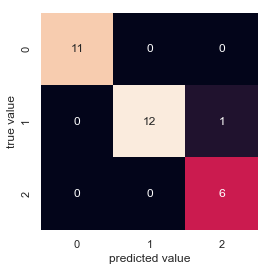

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

mat = confusion_matrix(ytest, ypredict)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

We can see from the above that we got 29 predictions right, and only one wrong.

Confusion matrices are particularly useful for binary classifiers (only two output states), where we can clearly see the number of false positives and false negatives.

This leads us to two important metrics: *precision* and *recall*. For a binary classifier, we have:

| Predicted | Actual | Result |
|-----------|--------|--------|
| Negative  | Negative | True Negative (TN) |
| Negative  | Positive | False Negative (FN) aka Type 2 error |
| Positive  | Negative | False Positive (FP) aka Type 1 error |
| Positive  | Positive | True Positive (TP) |

Then:

- *precision* or *Positive Predictive Value (PPV)* is $\frac{TP}{TP + FP}$
- *recall* or *sensitivity* or *true-positive rate* is $\frac{TP}{TP+FN}$
- *specificity* or *true-negative rate* is $\frac{TN}{TN+FP}$

![From Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

Consider an example: let's say we have a model that can predict if a patient has cancer or not. Then:

- if we predict cancer and they have cancer, this is a true positive
- if we predict no cancer and they have no cancer, this is a true negative
- if we predict cancer and they are cancer free, this is a false positive or type 1 error
- if we predict no cancer but they do have cancer, this is a false negative or type 2 error
- the *precision* of the model is the percentage of people who we predicted to have cancer that actually have cancer 
- the *recall* of the model is the percentage of patients with cancer that we managed to correctly predict
- the *specificity* of the model is the percentage of patients free of cancer that we managed to correctly predict

In addition, the *coverage* of a model is the proportion of the population for which a model makes a prediction. In many cases a model will output a weight or probability and if that does not meet some confidence threshold we will not use the prediction; e.g. if we only give predictions for 40% of the population the coverage is 40%. We could also refer to the coverage of a specific predicted value; say we have a multi-class classifier model that predicts class A 30% of the time, class B 50% of the time, and class C 20% of the time; we may refer to the "B coverage" as being 50%. There is some ambiguity here if the overall model coverage is not 100%, so use "coverage" in this way with care and make sure you clearly define what you mean for your use case.


## Unsupervised Learning - Dimensionality Reduction with PCA on Iris Dataset

We'll now look at an example of unsupervised learning, doing [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to do dimensionality reduction on the dataset so we can reduce it to two dimensions (which we'll call PCA1 and PCA2) for visualization.


In [16]:
from sklearn.decomposition import PCA 

model = PCA(n_components=2) # Reduce to two features/dimensions
model.fit(X)  # No need to specify y for unsupervised.
X_2D = model.transform(X) 
# See the first few entries
X_2D[:5]

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451]])

In [17]:
# Lets make a DataFrame and plot it.

df = pd.DataFrame(X_2D, columns=['PCA1', 'PCA2'])
df['species'] = y
df.head()

,PCA1,PCA2,species
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa


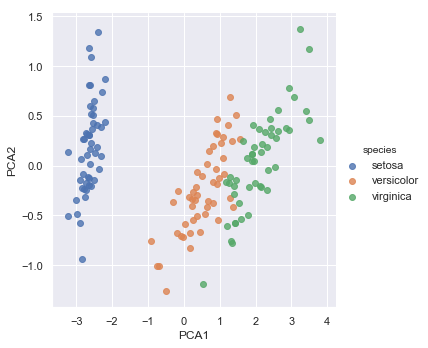

In [18]:
sns.lmplot("PCA1", "PCA2", hue='species', data=df, fit_reg=False);

The interesting thing to note is how the species are well separated. But when we generated the PCA values we did not tell the model anything about the species! This means that we should be able to use the input features (or the synthetic PCA features) and generate a good classification model. 

## Unsupervised Learning - Clustering on Iris Dataset

Now let's look at clustering. We'll use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering):

In [19]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model.fit(X)
y_kmeans = model.predict(X)

We can see how well we have done by plotting each cluster separately. We'll use the PCA pseudo-features so we can still use 2D plots.

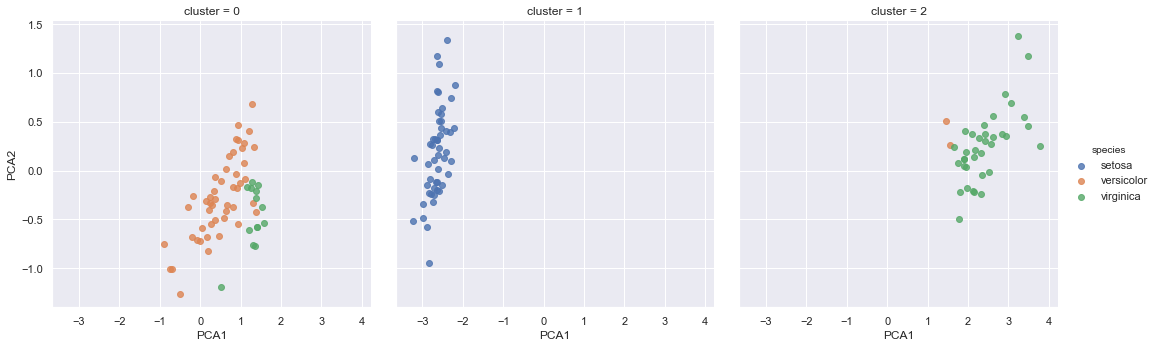

In [20]:
df['cluster'] = y_kmeans
sns.lmplot('PCA1', 'PCA2', data=df, hue='species', col='cluster', fit_reg=False); 

It's clear we have done very well in clustering in the blue case, but a bit less well with the other two species; this makes sense if you look at the earlier PCA plot, where you can see the blue species is more cleanly separated than the other two.

## Metrics for Evaluating Supervised Models

So far we have used classification accuracy, i.e. the percentage of correct predictions made, to evaluate models. This is really only suitable when there are an equal number of observations in each class, which is rarely the case, and that all predictions and prediction errors are equally important, which is often not the case. However, there are other metrics we can use; we've already mentioned precision and recall and we'll look at some more here and then show how they can be used in the next couple of examples.

### Classification Metrics

#### Log(arithmic) Loss

For multi-class classification where the model outputs a probability for each class we can use log-loss. This is commonly used in Kaggle competitions. It is defined as:

   $LL = - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} \log \, p_{ij}$

where $N$ is the number of samples or instances, $M$ is the number of possible labels, $y_{ij}$ is a binary indicator of whether or not label $j$ is the correct classification for instance $i$, and $p_{ij}$ is the model probability of assigning label $j$ to instance $i$. 

Smaller logloss is better with 0 representing a perfect classification.

#### Classification Report

This shows precision, recall, and F1 score (the harmonic mean of precision and recall).

    F1 score = 2 * ((precision * recall) / (precision + recall))

F1 scores range from 0 (worst) to 1 (best).

In [21]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        11
  versicolor       1.00      0.92      0.96        13
   virginica       0.86      1.00      0.92         6

   micro avg       0.97      0.97      0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



#### Area under ROC Curve

Area under ROC Curve (or AUC) represents a binary classifier’s ability to discriminate between positive and negative classes. Many binary classifiers output probabilities rather than 0/1, and it may be that the optimal split is not at 0.5; in fact it usually isn't. In this case we would want to know what probability value to pick as a threshold to distinguish between 0/1 with maximum accuracy. There is a trade-off - as we move the threshold we may get more true positives but we're also going to get more false positives. The AUC shows this trade-off this accuracy for different thresholds. We're not going to go into the details here; if you're interested there is good explanation at http://fastml.com/what-you-wanted-to-know-about-auc/ and a deep discussion at http://mlwiki.org/index.php/ROC_Analysis

### Regression Metrics

#### Mean Absolute Error

This is just the sum of the absolute values of the prediction errors; i.e.:

   $MAE = \frac{\sum\limits_{i=1}^n |y_i - \hat{y_i}|}{n}$

where $y_i$ is the actual value for the $i$th sample and $\hat{y_i}$ is the predicted value.


#### (Root) Mean Squared Error

This is the mean value of the square of the errors:

   $MSE = \frac{\sum\limits_{i=1}^n (y_i - \hat{y_i})^2}{n}$

To reduce the size of the value we can take the square root at the end; this gives us the Root Mean Squared Error or RMSE.

#### $R^2$

$r^2$ is also known as the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) and is 0 for no fit and 1 for a perfect fit. It is the proportion of the variation in the dependent variable that is predictable from the independent variable(s).


## Model Validation

We've seen one way of doing model validation; namely, splitting the data into a training set and a test set. In this section we'll look at a more sophisticated approach, namely cross-validation. We'll also see how we can use run into the problem of overfitting the data, and discuss the two concepts of bias and variance, and how these are traded-off.

### Overfitting the Training Data

Imagine that for our model, we just hashed the input features to the output label. If we ran this as a model, and passed the same training data in as test data, we would get an exact match every time, suggesting we have a 100% accurate model! But if we gave the model new data it hadn't seen, it would fail dismally, not even being able to predict a result. We could address this by using some kind of fuzzy matching of hash keys, so at least we could get predictions out, but the result is likely to be a poor model. This illustrates two problems:

- we shouldn't test with our training data or we are likely to get an unreasonable expectation of accuracy
- the model may 'fit' the training data very well but not generalize well to new data; we call this 'overfitting'

On the other hand, if we split into test and training data (where the test data is what we call a 'holdout set'), we lose some of our training data. What to do? Fortunately, there is a way we can use all of our data for training *and* for testing, using *cross-validation*!

### Cross Validation

Let's say we split the data in half; call the two halves H1 and H2. We could train a model on H1 and test it on H2, and get an accuracy A1. We could train a second model on H2 and test it on H1, and get an accuracy of A2. This suggests that if we train a model using all the data, the accuracy when tested on new data should be somewhere between A1 and A2.

In practice, we don't split in half. More generally, we will split the data into k pieces of *folds*, $F_1$, $F_2$, ..., $F_k$, and then build $k$ models, where the $n$th model uses $F_n$ as the test set and the remaining pieces excluding $F_n$ as the training set. The $k$ individual scores are then combined into a final score (mean and standard deviation). This is called *k-fold cross validation*. The size of each fold must  be large enough to be a reasonable sample of the problem, while allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on new data. Commonly-used values for k are 5 or 10, although we can go all the way to the extreme where $k$ is the size of the training set; this is called *leave-one-out cross validation*.  It is computationally expensive and the results have high variance.

We can do k-fold cross-validation in SciKit-Learn easily with `cross_val_score`:

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)  # 5-fold; this will call model.fit() 5 times with different data
scores.mean()

-17.237964129338877

### The Bias-Variance Trade-Off

*Bias* is a measure of error, or how far off predictions are from reality, due to erroneous assumptions; high bias is a sign of underfitting. *Variance* is an error from sensitivity to small fluctuations in the training set, and can be thought of as how closely the model fits to random noise in the training data (overfitting). Informally:

- bias is a measure of the error of the model against the training set
- variance is a measure of how much worse the model does with the test set versus the training set

What can we do if our model performs poorly? Assuming it is not just due to the data being completely random or having no actual dependence on our chosen features (in which case we will never be successful), we have several possible strategies:

- use a more complex model to get a better fit to training data, but at the risk of overfitting (reduce bias, increase variance)
- use a simpler model because we may have overfit the training data (increase bias, reduce variance)
- get more data to train on
- add more features (we'll talk about this later)

If we increased the complexity of our model, it would do better and better at fitting the training data, but at some point would start getting worse and worse at fitting the test data. This is the *bias-variance trade-off*; you can see it in the plot below where the vertical dashes line is the sweet spot we want to find.

![Bias-Variance Trade-Off](img/bias-variance.png)


### Learning Curves

The first two options we have, around model complexity, assume that the data is a fixed size. The third option is to add more data. As we add more data the optimal model will change. Assuming we capture the complexity of the data we are modeling, at some point we should have diminishing returns where adding more data doesn't significantly improve the model. This means that if we have a lot of data, it can be useful to measure how well the model is doing as we are training it, so we can stop when we reach the point where the further improvements are negligible. If we plot the training and validation scores as a function of the size of the data set we get the *learning curve*.

We would expect that a model will overfit a small dataset and underfit a large dataset, where 'small' and 'large' are dependent on the complexity of the model. We would also expect in almost every case that the training score is better than the validation score(or equivalently the training error is lower than the validation error). So a typical learning curve will look like:

![Learning Curve](img/learning-curve.png)

Note that the curve converges to some score as the amount of data increases. If the error score for the training set is high, that is high bias; if the scores for test and training are similar we have low variance, but a large gap between them is high variance. 

### Grid Search

Drawing plots of validation and learning curves can be useful except that in many cases models have multiple knobs (hyperparameters) to adjust; this makes using such visual aids more difficult. Instead, we can just train multiple versions of the model and have SciKit-Learn do the work, using a *[grid search](http://scikit-learn.org/stable/modules/grid_search.html)*.

To do this, we need to create a dictionary, where the keys are the different model constructor arguments, and the values are lists of values that we want to try. Then we can have SciKit-Learn find the best values for the parameters with cross-validation using `GridSearchCV`: 

    from sklearn.grid_search import GridSearchCV

    grid = GridSearchCV(model, param_dict, cv=10)
    grid.fit(X, y)
    print(grid.best_params_)
    
    final_model = grid.best_estimator_

It's also possible to use a list of dictionaries. SciKit-Learn will do an exhaustive search of the entire parameter space by default. `RandomizedSearchCV` can be used for a randomized search instead.


## Feature Engineering and Data Transforms

Apart from changing the model complexity, the main other strategies we have for improving our models are adding more data or adding more features and/or improving the existing features. We may be able to get more data from the problem domain, but in many cases we don't have that option. All is not lost though, as we can use other sources of data for dependent features, as well as sometimes synthesize new features from the features we are given. We will look at this in this section, along with ways of transforming our data to be more usable by our models.

SciKit-Learn helps us out here too; it supports a rich set of data transforms. The general approach is: create a transform, *fit* it to the data, and then apply it to *transform* the data. When new data arrives the previously fit transform can be applied to that for consistency. For the training data fit and transform can usually be combined into a call to `.fit_transform()`.

### Rescaling Data to a Min/Max Range

This can be done easily with:

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 1))
    X2 = scaler.fit_transform(X)
    
It applies the transform $x' = \frac{x - min(\bf{x})}{max(\bf{x}) - min(\bf{x})}$.

Rescaling to [0, 1] is the most common use case.


### Standardizing Distributions

To convert a Gaussian-distributed value to have mean 0 and standard deviation 1 we use z-score normalization:

$x' = \frac{x - E(\bf{x})}{\sqrt{Var(\bf{x})}}$

where $E(\bf{x})$ is the expected value or mean of $\bf{x}$ and the standard deviation is the square root of the variance of $\bf{x}$.


    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler().fit(X)
    X2 = scaler.transform(X)

### Normalizing to Unit Length Vectors

Normalized data has each row/observation have length 1 when treated as an n-dimensional vector.


    from sklearn.preprocessing import Normalizer

    scaler = Normalizer().fit(X)
    X2 = scaler.transform(X)

### Binarizing/Thresholding

*Binarizing* sets each value to either zero or one, splitting the input at some threshold value. 

    from sklearn.preprocessing import Binarizer

    binarizer = Binarizer(threshold=0.0).fit(X)
    binaryX = binarizer.transform(X)

### Handling Categorical Data

Many ML algorithms rely on the inputs being numeric quantities. So how should we deal with categorical data? We could use a simple mapping of categories to numbers, but this is a bad idea, as the models assume that the values have some numerical significance.

A better approach is to use *1-hot encoding*. We saw this briefly in the Pandas notebook. The idea is to add a new column for every unique value of that categorical variable, and then encode the values in those columns as zeroes except for the column corresponding to the original value.

Here is a simple example:

In [23]:
data = [
        {'color': 'red'},
        {'color': 'blue'},
        {'color': 'green'},
        {'color': 'blue'}
]

In [24]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False, dtype=int)
v.fit_transform(data)  # We could use .transform() but would need to set a 'vocabulary'

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=int64)

In [25]:
v.get_feature_names()

['color=blue', 'color=green', 'color=red']

If we have a lot of different values for the category, this can add many columns, which may affect which modeling approaches we can use later. In this case you probably will want to set the `sparse` argument to `True` to save memory.

### Handling Text

For text, there are a few different options. Most commonly we will split the text up into a sequence of words. In many cases we will remove *stop words* (common words like 'and' and 'the'), and may perform operations such as 'stemming', 'named entity recognition', 'parts of speech tagging', etc. We're not going to go into these here; see the [SpaCy NLP library](https://spacy.io/) for examples.

We can use a similar approach to the categorical data, and turn each unique word into a new column. We can encode with 0/1 like one-hot, or use word counts. Let's look at the latter. In this case `fit_transform` returns a sparse array so we turn it back into a DataFrame:

In [26]:
data = [
    "the cat sat on the mat",
    "the mat belonged to the rat",
    "the hat was on the mat",
    "the cat ate the rat",
    "the cat now has the hat"
]

from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
X = v.fit_transform(data)
pd.DataFrame(X.toarray(), columns=v.get_feature_names())

,ate,belonged,cat,has,hat,mat,now,on,rat,sat,the,to,was
0,0,0,1,0,0,1,0,1,0,1,2,0,0
1,0,1,0,0,0,1,0,0,1,0,2,1,0
2,0,0,0,0,1,1,0,1,0,0,2,0,1
3,1,0,1,0,0,0,0,0,1,0,2,0,0
4,0,0,1,1,1,0,1,0,0,0,2,0,0


The problem with word counts, especially if we don't remove stop words, is that common words get scored highly, which may not always be desirable. What we want to score highly are words that are common *in this row* that are not common *across all rows*. That should weight words that are significant to the particular row. We can do this with *[Term Frequency - Inverse Document Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)* or TF-IDF scores. In our small example this doesn't quite have the desired effect but the code is useful to show:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer()
X = v.fit_transform(data)
pd.DataFrame(X.toarray(), columns=v.get_feature_names())

,ate,belonged,cat,has,hat,mat,now,on,rat,sat,the,to,was
0,0.000000,0.000000,0.360239,0.000000,0.000000,0.360239,0.000000,0.433975,0.000000,0.537901,0.512625,0.000000,0.00000
1,0.000000,0.499522,0.000000,0.000000,0.000000,0.334536,0.000000,0.000000,0.403011,0.000000,0.476050,0.499522,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.421800,0.350132,0.000000,0.421800,0.000000,0.000000,0.498244,0.000000,0.52281
3,0.576615,0.000000,0.386166,0.000000,0.000000,0.000000,0.000000,0.000000,0.465209,0.000000,0.549520,0.000000,0.00000
4,0.000000,0.000000,0.334536,0.499522,0.403011,0.000000,0.499522,0.000000,0.000000,0.000000,0.476050,0.000000,0.00000


> There is a recent paper discussing an alternative to TF-IDF, *[Contextual Salience](https://arxiv.org/abs/1803.08493)*, that may be interesting.

### Handling Missing Data

We saw a bit about handling missing data in the Pandas notebook. SciKit-Learn has some useful functionality to help us here too, namely the `Imputer`:

    from sklearn.preprocessing import Imputer
        
    X = Imputer(strategy='mean').fit_transform(X)

The above code will replace any `nan` values in the original array X with the mean of the non-NaN values in that column. Other strategies are `median` and `most_frequent`.


### Synthesizing and Adding Features

In many cases, we will want to create features that are not directly available in the data, but are derived or synthesized from these. For example, the data may have city names, which we may want to turn into latitude/longitude, or perhaps include data like the population of the city. In such cases we would need to include the necessary tables to look up these features from the input features before fitting or predicting with the model.

Another common case is to improve the power of regression. Regression fits a line in 2D, or a plane in higher dimensions, but this is linear. What if a polynomial of higher order would be a much better fit? We can still use linear regression, all we need to do is add features that are higher-order powers of the input features!

Consider this data:

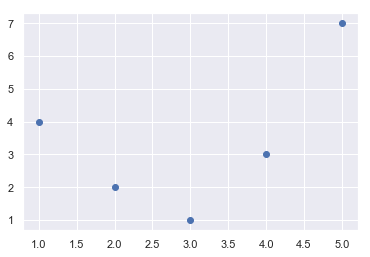

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);
 

If we just use these features as is and fit a linear model we get this:

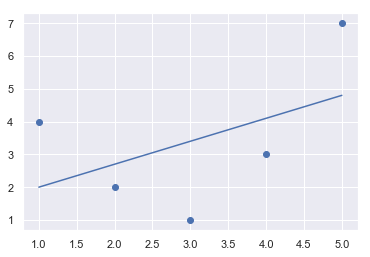

In [29]:
from sklearn.linear_model import LinearRegression
        
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

Let's add some synthetic features that are higher-order powers of X:

In [30]:
from sklearn.preprocessing import PolynomialFeatures
        
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
X2 

array([[  1.,   1.,   1.],
       [  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.],
       [  5.,  25., 125.]])

Now we can fit a linear model to this extended set of features, and plot the results; you'll see we have a much better fit:

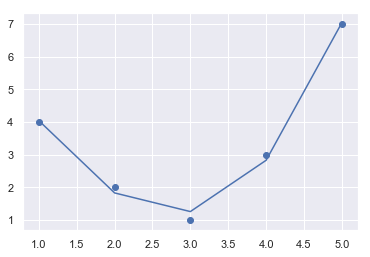

In [31]:
model = LinearRegression().fit(X2, y)
        
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit); 

There is a package that can do some feature synthesis for you: https://www.featuretools.com/

### Reducing Features

Sometimes the right thing to do is to reduce the number of features. For example, we may have performance constraints (memory/CPU) that mean we need to shrink the model. Or we may have extraneous features that aren't adding any value.

We've already seen one approach to this, namely PCA. There are other approaches too:

- we can use decision tree models to rank the importance of features:

In [32]:
# Set up the Iris dataset again
X = iris.drop('species', axis=1)
y = iris['species']

In [33]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(list(zip(X.columns, model.feature_importances_)))

[('sepal_length', 0.08019426832661203), ('sepal_width', 0.03295605519858127), ('petal_length', 0.369924094484191), ('petal_width', 0.5169255819906157)]


/home/pybokeh/envs/py3.7.2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


- we can use Recursive Feature Elimination (RFE) to recursively remove attributes and build a model based on those that remain, then use the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute. The example below uses logistic regression but any algorithm could be used:

In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 3)  # Reduce to top 3
fit = rfe.fit(X, y)
print(f"Feature Ranking: {fit.ranking_}")
print(f"Selected Features: {X.columns[fit.support_]}")

Feature Ranking: [2 1 1 1]
Selected Features: Index(['sepal_width', 'petal_length', 'petal_width'], dtype='object')


/home/pybokeh/envs/py3.7.2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/pybokeh/envs/py3.7.2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/pybokeh/envs/py3.7.2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/pybokeh/envs/py3.7.2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


- We can use a chi-squared test to select the features with the strongest relationships with the output. The code below selects the three best features:

In [35]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X, y)

np.set_printoptions(precision=3)
print(fit.scores_)

[ 10.818   3.711 116.313  67.048]


## Pipelines

Sometimes we need to chain computations in SciKit. For example, when we looked at adding polynomial synthetic features, we produced a transformed feature vector before applying the linear model. This is a common enough operation that there is a mechanism available for it, namely pipelines.

In that example, the code had a form similar to:

````python
X2 = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X)
model = LinearRegression().fit(X2, y)
yfit = model.predict(trainy)
````

To write this as a pipeline, we could use:

````python
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), LinearRegression())
model = pipeline.fit(X, y)
yfit = model.predict(trainy)
````

Pipelines can help avoid a common mistake of leaking information from the test data set into the training data set. E.g. if we scale all data to be in range [0..1] but include the test data when determining the scale factors, this could be problematic. By doing the scaling in a pipeline along with model fitting this is less likely to occur. 

A more advanced feature of pipelines is the FeatureUnion. This is beyond the scope of this notebook but worth knowing about. See http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html.

Using a regression model with polynomial synthetic features is a useful and common enough approach that we can define a utility function for this; we will use this later:

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs)) 

## A Classification Example - Breast Cancer

A description of this data is at http://scikit-learn.org/stable/datasets/index.html#datasets, section 5.14. The columns are mean, standard error, and "worst" values of the following ten features, making 30 features in all,
followed by the class (malignant or benign).

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

In [37]:
from sklearn.datasets import load_breast_cancer

features = load_breast_cancer().feature_names
X, y = load_breast_cancer(return_X_y=True)
features

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [38]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1, test_size=0.2)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth=8)
model.fit(Xtrain, ytrain)
ypredict = model.predict(Xtest)
accuracy_score(ytest, ypredict)

0.9473684210526315

Let's see what the most important features are:

In [40]:
from operator import itemgetter
sorted(list(zip(features, model.feature_importances_)), key=itemgetter(1), reverse=True)[:10]

[('worst perimeter', 0.7292904295142022),
 ('worst texture', 0.0823135090517362),
 ('worst concave points', 0.044043366134688115),
 ('concave points error', 0.04173833276000459),
 ('mean concave points', 0.02884436283817093),
 ('worst area', 0.02677294371118715),
 ('mean texture', 0.020489726991274982),
 ('mean smoothness', 0.009327239667796928),
 ('worst compactness', 0.007825937392500861),
 ('perimeter error', 0.006260749914000689)]

## A Regression Example - Boston Housing Prices

A description of this data is at http://scikit-learn.org/stable/datasets/index.html#datasets, section 5.13. The columns are:

- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centers
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per \$10,000
- PTRATIO pupil-teacher ratio by town
- B $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
- LSTAT \% lower status of the population
- MEDV Median value of owner-occupied homes in $1000’s

MEDV is usually the target when building models with this data.

In [41]:
from sklearn.datasets import load_boston

features = load_boston().feature_names
X, y = load_boston(return_X_y=True)
features

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Let's apply a polynomial regression model and see how the model validation changes as we use different degrees of polynomials. We'll use the utility function we defined earlier:

In [42]:
import numpy as np
from sklearn.model_selection import validation_curve

degree = np.arange(0, 5)  # We'll try up to a 4th degree polynomial
train_score, val_score = validation_curve(PolynomialRegression(), X, y, 'polynomialfeatures__degree', degree, cv=7)

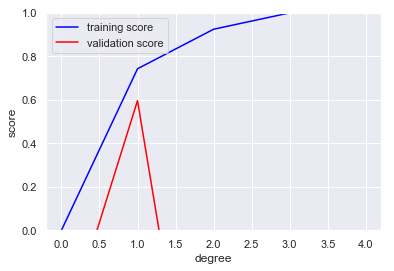

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

We can use grid search to find a good model; we can vary a couple of other hyperparameters too:

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': np.arange(5),
    'linearregression__fit_intercept': [True, False],
    'linearregression__normalize': [True, False]
}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y)
grid.best_params_

/home/pybokeh/envs/py3.7.2/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 1}

## Combining Model Predictions with Ensembles

One way to improve performance is to combine the results of several models. There are several ways this can be done; for example:

* *Bagging* - building multiple models (typically of the same type) from different subsamples of the training dataset. Sampling is done with replacement, and the predictions are combined and averaged into a final result.
* *Boosting* - building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the sequence of models.
* *Voting* - building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions. *Stacking* is a voting approach which also learns the weights to give to each vote.

If we have a model type in `model`, we can do bagging with:

```python
from sklearn.ensemble import BaggingClassifier

model = ...
model = BaggingClassifier(base_estimator=model, n_estimators=50, random_state=0)
...
```

Random forests are another example of bagging. [AdaBoost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost) is an example of a popular boosting algorithm.


## Interpreting Models

Once we have a good model, how do we interpret the results? That is, how can we justify the prediction when it is questioned?

For decision trees, this is not that difficult - the path through the decision tree illustrates the "reasoning" behind the decision. However, for many other models there is no intuitive interpretation. Getting a ranking of feature importance is helpful but not complete.

There has been some interesting work in this area for classification models. The approach is to rely on a form of sensitivity analysis - ask, "what small changes in the inputs would result in different outputs?". This can be done one a case by case basis, with the learnings often being generalizable to cover more cases.

This is really out of scope for this notebook, but if you are interested in learning more, the seminal work is [LIME](https://homes.cs.washington.edu/~marcotcr/blog/lime/), and other popular approaches are [SHAP](https://github.com/slundberg/shap) and [Skater](https://www.datascience.com/resources/tools/skater).

## Taking It Further

*[Data leakage](https://medium.com/@colin.fraser/the-treachery-of-leakage-56a2d7c4e931)* is something to look out for, and [high-dimensional data](https://en.wikipedia.org/wiki/Curse_of_dimensionality)  introduces some interesting effects that you should be aware of.

A good practical online course can be found here: https://www.coursera.org/specializations/data-science-python while https://www.coursera.org/specializations/machine-learning covers more theory but in a gentle way.

If you want to learn about deep learning, I recommend the courses at http://www.fast.ai/ and https://www.deeplearning.ai/

There are a number of machine learning newsletters if you want to keep up with new developments, but the best is probably this one: https://www.getrevue.co/profile/wildml

Google's Martin Zinkevich maintains a document with a [lot of good hard-won advice](http://martin.zinkevich.org/rules_of_ml/rules_of_ml.pdf). 

Pedro Domingos of University of Washington wrote a [great article](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) with some similar lessons in CACM: ; there is a good restatement of the content here: https://medium.com/@james_aka_yale/12-useful-things-to-know-about-machine-learning-c599be92c98d.

